# LoRa Data Analysis - Adaptive Data Rate


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Bandwidth: 125 kHz

End nodes:
- used an adaptive data rate algorithm (ADR) for communication parameters selection.

Access points:
- two access points were used to avoid a duty cycle depletion

Initial declaration

In [186]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib_inline as mpl_inl # import matplotlib
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

mpl_inl.backend_inline.set_matplotlib_formats('svg') # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable
subfolder = 'data/s1r5'
uplink_message_file = './' + subfolder + '/uplink_messages.csv'
algorithm = 'adr'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [187]:
uplink_data = pd.read_csv(uplink_message_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [188]:
uplink_data.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,...,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id,dev_id,application_id,battery
0,41076,QjVCQkJCAA==,10.25,-95,33991,t,2023-09-21 12:45:38.617,11621,866100000,11,...,-1211744222,4/5,125000,327,1,777777,d3d3,41046,NaN,NaN
1,41077,QjVCQkJCAA==,9.25,-59,33332,t,2023-09-21 12:45:45.197,51853,866900000,12,...,-1211737777,4/5,125000,97,1,777777,qqqq,41047,NaN,NaN
2,41078,QjVCQkJCAA==,13.00,-56,33332,t,2023-09-21 12:45:45.22,24618,866100000,11,...,-1211737704,4/5,125000,227,1,777777,7u7u,41048,NaN,NaN
3,41079,QjVCQkJCAA==,9.75,-80,101,f,2023-09-21 12:45:50.134,11623,866300000,7,...,-1211732497,4/5,125000,328,1,333333,d3d3,41049,NaN,NaN
4,41080,QjVCQkJCAA==,9.00,-81,30863,t,2023-09-21 12:45:50.136,11623,866300000,7,...,-1211732494,4/5,125000,328,1,777777,d3d3,41050,NaN,NaN


Let us have a look for different values to get an overview of overall values of different network parameters.

In [189]:
uplink_data.describe()

,id,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,bandwidth,msg_group_number,message_type_id,ap_id,dev_id,application_id,battery
count,359.000000,359.000000,359.000000,359.000000,359.000000,3.590000e+02,359.000000,359.0,3.590000e+02,359.0,359.000000,359.0,359.000000,359.000000,0.0,0.0
mean,41255.000000,8.492340,-77.788301,11038.094708,29965.944290,8.665396e+08,10.467967,0.0,-1.208216e+09,125000.0,258.752089,1.0,562364.030641,41225.000000,NaN,NaN
std,103.778611,2.450155,13.539505,11383.142039,17723.895314,3.130242e+05,1.940009,0.0,2.968879e+06,0.0,97.506151,0.0,222427.662740,103.778611,NaN,NaN
min,41076.000000,-12.250000,-113.000000,17.000000,1040.000000,8.661000e+08,7.000000,0.0,-1.211744e+09,125000.0,63.000000,1.0,333333.000000,41046.000000,NaN,NaN
25%,41165.500000,7.750000,-88.000000,122.000000,14312.000000,8.663000e+08,9.000000,0.0,-1.211610e+09,125000.0,201.500000,1.0,333333.000000,41135.500000,NaN,NaN
50%,41255.000000,8.750000,-78.000000,7475.000000,28024.000000,8.665000e+08,11.000000,0.0,-1.208044e+09,125000.0,237.000000,1.0,777777.000000,41225.000000,NaN,NaN
75%,41344.500000,9.750000,-69.000000,20324.000000,45082.000000,8.669000e+08,12.000000,0.0,-1.204492e+09,125000.0,348.500000,1.0,777777.000000,41314.500000,NaN,NaN
max,41434.000000,13.250000,-53.000000,36000.000000,63089.000000,8.669000e+08,12.000000,0.0,-1.204326e+09,125000.0,411.000000,1.0,777777.000000,41404.000000,NaN,NaN


### Payload Length

In [190]:
uplink_data['payload_len'] = uplink_data.app_data.apply(len)
uplink_data.payload_len.describe()

count    359.0
mean      12.0
std        0.0
min       12.0
25%       12.0
50%       12.0
75%       12.0
max       12.0
Name: payload_len, dtype: float64

In [191]:
payload_len = round(statistics.mean(uplink_data.payload_len), 2)
print(f'Mean value of payload length is {payload_len}.')

Mean value of payload length is 12.


### Spreading Factor

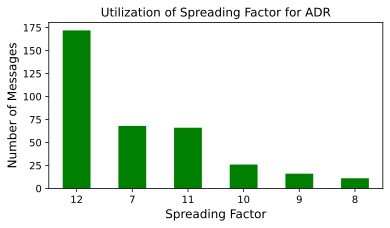

In [192]:
hist = uplink_data.spf.value_counts().plot(kind='bar',rot=0,color='g',figsize=(6,3))
hist.set_xlabel('Spreading Factor',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Spreading Factor for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-speading-factor.svg', dpi=300)
plt.show()

### Utilization of Frequency

Frequency is stored in Hz, so we need to convert it to MHz.

In [193]:
uplink_frequency = uplink_data.frequency / 1000000

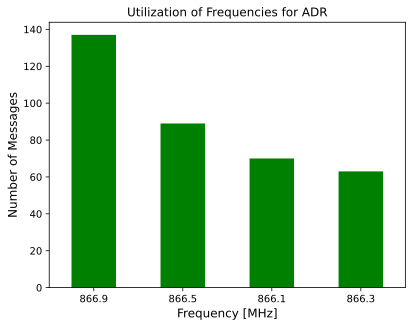

In [194]:
hist = uplink_frequency.value_counts().plot(kind='bar',rot=0,color='g')
hist.set_xlabel('Frequency [MHz]',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Frequencies for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-frequencies.svg', dpi=300)
plt.show()

### Received Signal Strength Indicator

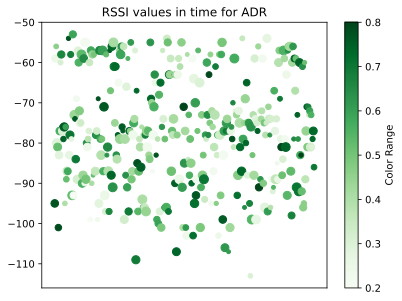

In [195]:
x = uplink_data.id
y = uplink_data.rssi
hist.set_xlabel('Time', fontsize=12)
#hist.set_ylabel('Number of Messages', fontsize=12)

# size and color:
sizes = np.random.uniform(15, 80, len(x))

# Define the colormap 'Greens' which is a gradient of green
cmap = plt.get_cmap('Greens')

# Define vmin and vmax values to control the gradient
vmin = 0.2
vmax = 0.8

# Generate random values within the range [vmin, vmax]
normalized_values = (np.random.rand(len(x)) * (vmax - vmin)) + vmin

fig, ax = plt.subplots()
sc = ax.scatter(x, y, s=sizes, c=normalized_values, cmap=cmap, vmin=vmin, vmax=vmax)

# Add colorbar for reference
cbar = plt.colorbar(sc)
cbar.set_label('Color Range')

ax.set_xticks([])

plt.title(f'RSSI values in time for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-rssi.svg', dpi=300)
plt.show()

### Different Types of Messages

Let us analyze the ratio of message types.

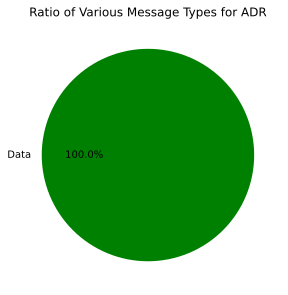

In [196]:
message_types = uplink_data.message_type_id.value_counts()

plt.pie(message_types, autopct='%1.1f%%', labels=['Data'], colors=['g', 'orange'])
plt.title(f'Ratio of Various Message Types for {algorithm.upper()}')

# Output is automatically exported
plt.savefig(f'./{subfolder}/{algorithm}-message-type.svg', dpi=300)
plt.show()

## Analysis of End Nodes

Analysis of certain aspects of end devices.

In [197]:
print(f'Number of end nodes partiipating in the experiment is {uplink_data.node_id.nunique()}.')

Number of end nodes partiipating in the experiment is 10.


In [198]:
uplink_data.node_id.describe()

count      359
unique      10
top       ZmZm
freq        58
Name: node_id, dtype: object

In [185]:
unique_ens = len(uplink_data.node_id.unique())
unique_aps = len(uplink_data.ap_id.unique())

print(f'Total number of connected end devices: {unique_ens}')
print(f'Total number of connected access points: {unique_aps}')

Total number of connected end devices: 10
Total number of connected access points: 2


## End Nodes CSV Protocol Analysis

In [126]:
dev_id = 'zMzM'
end_nodes_file = f'./{subfolder}/{dev_id}.csv'

end_nodes = pd.read_csv(end_nodes_file, delimiter=',')

FileNotFoundError: [Errno 2] No such file or directory: './data/s1r2/zMzM.csv'

In [107]:
end_nodes.head()

,seq,frequency,pw,sf
0,1,866.1,14,11
1,2,866.9,14,12
2,3,866.9,14,12
3,4,866.9,14,12
4,1,866.1,14,11


In [108]:
end_nodes.describe()

,seq,frequency,pw,sf
count,1044.000000,1044.000000,1044.000000,1044.000000
mean,2846.848659,866.739847,13.935824,10.825670
std,10905.784308,0.279334,0.245184,2.066087
min,1.000000,866.100000,13.000000,7.000000
25%,2.000000,866.500000,14.000000,11.000000
50%,3.000000,866.900000,14.000000,12.000000
75%,4.000000,866.900000,14.000000,12.000000
max,65441.000000,866.900000,14.000000,12.000000


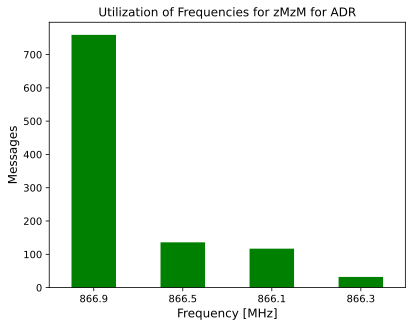

In [109]:
hist = end_nodes.frequency.value_counts().plot(kind='bar',rot=0,color='g')
hist.set_xlabel('Frequency [MHz]',fontsize=12)
hist.set_ylabel('Messages',fontsize=12)

plt.title(f'Utilization of Frequencies for {dev_id} for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-{dev_id}-frequencies.svg', dpi=300)
plt.show()

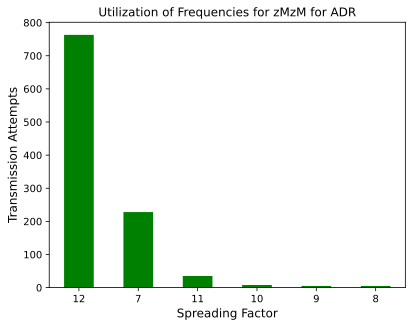

In [110]:
hist = end_nodes.sf.value_counts().plot(kind='bar',rot=0,color='g')
hist.set_xlabel('Spreading Factor',fontsize=12)
hist.set_ylabel('Transmission Attempts',fontsize=12)

plt.title(f'Utilization of Frequencies for {dev_id} for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-{dev_id}-sf.svg', dpi=300)
plt.show()

## Ratio of Message Transmission Attempts to Successful Message Deliveries (MTAMD)

Evaluation of MTAMD for end nodes.

In [199]:
end_nodes = uplink_data.groupby('node_id')

seq_tolerance = 15
first_seq = 0
last_seq = 0
prev_seq = 0
prev_node_id = ""
msg_count = 0
msg_delivered = 0
total_msg_count = 0

for name,group in end_nodes:
    #print('ID:' + str(name))
    #print(group['seq'])

    for seq in group['seq']:
        #print(name, seq)
        if (abs(prev_seq - seq) > seq_tolerance):
            total_msg_count += prev_seq - first_seq
            #print(prev_node_id, prev_seq, seq, first_seq, prev_seq - first_seq, msg_count)
            msg_delivered += msg_count
            first_seq = seq
            msg_count = 0
        if prev_seq != seq:
            msg_count += 1
        prev_seq = seq
        prev_node_id = name
    pdr = round(msg_delivered / total_msg_count * 100, 2)
    print(f'{name} reached PDR {pdr}%')
    first_seq = 0
    last_seq = 0
    prev_seq = 0
    msg_count = 0
    msg_delivered = 0
    total_msg_count = 0


3d3d reached PDR 121.43%
7u7u reached PDR 76.0%
VVVV reached PDR 77.27%
ZmZm reached PDR 65.71%
d3d3 reached PDR 69.57%
iIiI reached PDR 77.27%
mZmZ reached PDR 80.0%
qqqq reached PDR 65.71%
u7u7 reached PDR 70.83%
zMzM reached PDR 75.0%


The End.